In [1]:
%matplotlib_svg
import pylab as pl
from sympy import *
import numpy as np
%init_sympy_printing
import sympy
sympy.__version__

'0.7.6'

# SymPy-符号运算好帮手

## 从例子开始

### 封面上的经典公式

In [4]:
from sympy import *
E**(I*pi) + 1

In [5]:
x = symbols("x")
expand( E**(I*x) )

In [6]:
expand(exp(I*x), complex=True)

In [7]:
x = Symbol("x", real=True)
expand(exp(I*x), complex=True)    

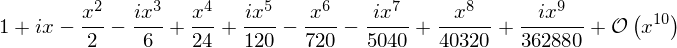

In [8]:
tmp = series(exp(I*x), x, 0, 10)
tmp

In [8]:
re(tmp)

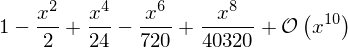

In [12]:
series(cos(x), x, 0, 10)

In [10]:
im(tmp)

In [11]:
series(sin(x), x, 0, 10)

### 球体体积

In [13]:
integrate(x*sin(x), x)

In [14]:
integrate(x*sin(x), (x, 0, 2*pi))

In [10]:
x, y = symbols('x, y')
r = symbols('r', positive=True)
circle_area = 2 * integrate(sqrt(r**2 - x**2), (x, -r, r))
circle_area

In [11]:
circle_area = circle_area.subs(r, sqrt(r**2 - x**2))
circle_area

In [12]:
integrate(circle_area, (x, -r, r))

### 数值微分

In [3]:
x = symbols('x', real=True)
h = symbols('h', positive=True)
f = symbols('f', cls=Function)

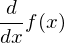

In [5]:
f_diff = f(x).diff(x, 1)
f_diff

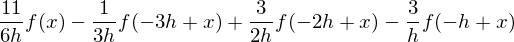

In [6]:
expr_diff = as_finite_diff(f_diff, [x, x-h, x-2*h, x-3*h])
expr_diff

In [7]:
sym_dexpr = f_diff.subs(f(x), x*exp(-x**2)).doit()
sym_dexpr

In [8]:
sym_dfunc = lambdify([x], sym_dexpr, modules="numpy")
sym_dfunc(np.array([-1, 0, 1]))

array([-0.36787944,  1.        , -0.36787944])

In [9]:
print((expr_diff.args))

(-3*f(-h + x)/h, -f(-3*h + x)/(3*h), 3*f(-2*h + x)/(2*h), 11*f(x)/(6*h))


In [26]:
w = Wild("w")
c = Wild("c")
patterns = [arg.match(c * f(w)) for arg in expr_diff.args]

In [27]:
print((patterns[0]))

{w_: -h + x, c_: -3/h}


In [28]:
coefficients = [t[c] for t in sorted(patterns, key=lambda t:t[w])]
print(coefficients)

[-1/(3*h), 3/(2*h), -3/h, 11/(6*h)]


In [29]:
coeff_arr = np.array([float(coeff.subs(h, 1e-3)) for coeff in coefficients])
print(coeff_arr)

[ -333.33333333  1500.         -3000.          1833.33333333]


In [30]:
def moving_window(x, size):
    from numpy.lib.stride_tricks import as_strided    
    x = np.ascontiguousarray(x)
    return as_strided(x, shape=(x.shape[0] - size + 1, size), 
                      strides=(x.itemsize, x.itemsize))

x_arr = np.arange(-2, 2, 1e-3)
y_arr = x_arr * np.exp(-x_arr * x_arr)
num_res = (moving_window(y_arr, 4) * coeff_arr).sum(axis=1)
sym_res = sym_dfunc(x_arr[3:])
print((np.max(abs(num_res - sym_res))))

4.08944167418e-09


In [31]:
def finite_diff_coefficients(f_diff, order, h):
    v = f_diff.variables[0]
    points = [x - i * h for i in range(order)]
    expr_diff = as_finite_diff(f_diff, points)
    w = Wild("w")
    c = Wild("c")
    patterns = [arg.match(c*f(w)) for arg in expr_diff.args]
    coefficients = np.array([float(t[c]) 
                             for t in sorted(patterns, key=lambda t:t[w])])
    return coefficients

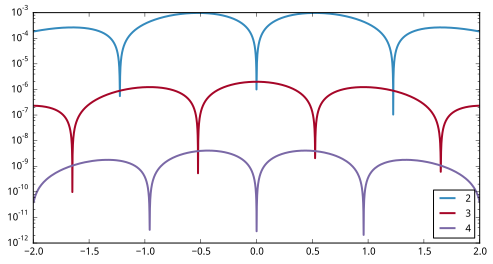

In [32]:
#%figonly=比较不同点数的数值微分的误差
fig, ax = pl.subplots(figsize=(8, 4))

for order in range(2, 5):
    c = finite_diff_coefficients(f_diff, order, 1e-3)
    num_diff = (moving_window(y_arr, order) * c).sum(axis=1)
    sym_diff = sym_dfunc(x_arr[order-1:])
    error = np.abs(num_diff - sym_diff)
    ax.semilogy(x_arr[order-1:], error, label=str(order))
    
ax.legend(loc="best");